1) Get the provided datasets from D2L. Then for each dataset:
1) Visualize the data w/ labels using 2 or 3-D tSNE.
1) Write your own version of an active learning rare class discovery algorithm.

1) Run your code on the dataset and keep track of the number of classes discovered vs. number of
queries.

1) Plot that (# classes discovered vs. # queries).

1) Rerun the same experiment using a random query strategy.

1) Plot the results from the random algorithm on the same plot.


In [40]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.markers as mmarkers
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import animation

from mpl_toolkits.mplot3d import axes3d

from numpy.random import rand


import os

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier



from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from IPython.display import Image
from IPython.display import HTML
from datetime import datetime

In [41]:
#homework framework
#check data path     
data_path = os.path.normpath(os.getcwd() + '/../data/')


mnist_data_file = '/X_and_y_actual.npz'
#mnist_labels_file = 'mnist_full_labels_784.npy'

#objective 1, get Get the provided datasets from D2L. Then for each dataset:
if os.path.exists(data_file := os.path.normpath(data_path + mnist_data_file)):
    X_and_y = np.load(data_file, allow_pickle=True)
    X = X_and_y['arr_0']
    y = X_and_y['arr_1']

#if os.path.exists(os.getcwd() + data_path + mnist_labels_file):
#    y = np.load(os.getcwd() + data_path + mnist_labels_file, allow_pickle=True)

#define report location
report_folder = os.path.normpath(os.getcwd() + '/report/')
report_images = os.path.normpath(report_folder + '/resources/images/')

#check if the folder exists
if not os.path.exists(report_images):
    os.makedirs(report_images)
    
if not os.path.exists(report_images):
    print(f'{report_images} could not be created')
    exit()

print(f'Using {report_images} for report images.')


Using c:\dev\csc730\assignment 9\report\resources\images for report images.


Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'bri_0' 'bri_1' 'bri_2' 'bri_3'
 'bri_4' 'bri_5' 'bri_6' 'bri_7' 'bri_8' 'bri_9' 'can_0' 'can_1' 'can_2'
 'can_3' 'can_4' 'can_5' 'can_6' 'can_7' 'can_8' 'can_9' 'dot_0' 'dot_1'
 'dot_2' 'dot_3' 'dot_4' 'dot_5' 'dot_6' 'dot_7' 'dot_8' 'dot_9' 'fog_0'
 'fog_1' 'fog_2' 'fog_3' 'fog_4' 'fog_5' 'fog_6' 'fog_7' 'fog_8' 'fog_9'
 'gla_0' 'gla_1' 'gla_2' 'gla_3' 'gla_4' 'gla_5' 'gla_6' 'gla_7' 'gla_8'
 'gla_9' 'imp_0' 'imp_1' 'imp_2' 'imp_3' 'imp_4' 'imp_5' 'imp_6' 'imp_7'
 'imp_8' 'imp_9' 'mot_0' 'mot_1' 'mot_2' 'mot_3' 'mot_4' 'mot_5' 'mot_6'
 'mot_7' 'mot_8' 'mot_9' 'ori_0' 'ori_1' 'ori_2' 'ori_3' 'ori_4' 'ori_5'
 'ori_6' 'ori_7' 'ori_8' 'ori_9' 'rot_0' 'rot_1' 'rot_2' 'rot_3' 'rot_4'
 'rot_5' 'rot_6' 'rot_7' 'rot_8' 'rot_9' 'sca_0' 'sca_1' 'sca_2' 'sca_3'
 'sca_4' 'sca_5' 'sca_6' 'sca_7' 'sca_8' 'sca_9' 'she_0' 'she_1' 'she_2'
 'she_3' 'she_4' 'she_5' 'she_6' 'she_7' 'she_8' 'she_9' 'sho_0' 'sho_1'
 'sho_2' 'sho_3' 'sho_4' 'sho_5' 'sh

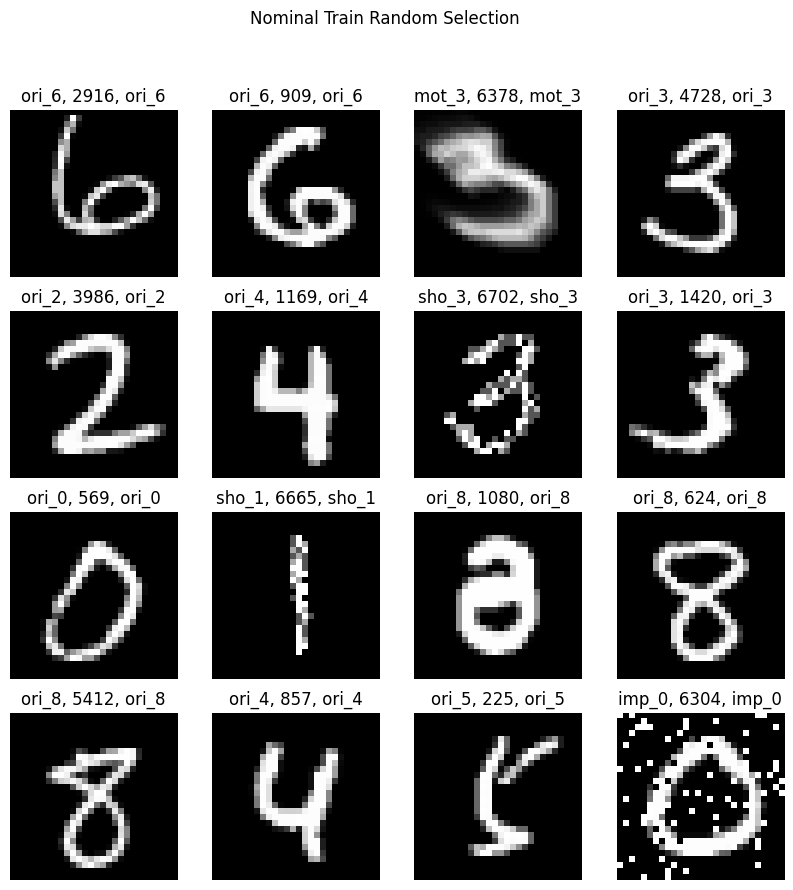

Unique labels: ['bri_0' 'bri_1' 'bri_2' 'bri_3' 'bri_4' 'bri_5' 'bri_6' 'bri_7' 'bri_8'
 'bri_9' 'can_0' 'can_1' 'can_2' 'can_3' 'can_4' 'can_5' 'can_6' 'can_7'
 'can_8' 'can_9' 'dot_0' 'dot_1' 'dot_2' 'dot_3' 'dot_4' 'dot_5' 'dot_6'
 'dot_7' 'dot_8' 'dot_9' 'fog_0' 'fog_1' 'fog_2' 'fog_3' 'fog_4' 'fog_5'
 'fog_6' 'fog_7' 'fog_8' 'fog_9' 'gla_0' 'gla_1' 'gla_2' 'gla_3' 'gla_4'
 'gla_5' 'gla_6' 'gla_7' 'gla_8' 'gla_9' 'imp_0' 'imp_1' 'imp_2' 'imp_3'
 'imp_4' 'imp_5' 'imp_6' 'imp_7' 'imp_8' 'imp_9' 'mot_0' 'mot_1' 'mot_2'
 'mot_3' 'mot_4' 'mot_5' 'mot_6' 'mot_7' 'mot_8' 'mot_9' 'ori_0' 'ori_1'
 'ori_2' 'ori_3' 'ori_4' 'ori_5' 'ori_6' 'ori_7' 'ori_8' 'ori_9' 'rot_0'
 'rot_1' 'rot_2' 'rot_3' 'rot_4' 'rot_5' 'rot_6' 'rot_7' 'rot_8' 'rot_9'
 'sca_0' 'sca_1' 'sca_2' 'sca_3' 'sca_4' 'sca_5' 'sca_6' 'sca_7' 'sca_8'
 'sca_9' 'she_0' 'she_1' 'she_2' 'she_3' 'she_4' 'she_5' 'she_6' 'she_7'
 'she_8' 'she_9' 'sho_0' 'sho_1' 'sho_2' 'sho_3' 'sho_4' 'sho_5' 'sho_6'
 'sho_7' 'sho_8' 'sho_9' 'spa_0' 'sp

In [42]:
#generate example data figures

print(f'Unique labels: {np.unique(y)}')
#fix dataset, if label is length 1 then add 'ori_' as a prefix

y = np.array([f'ori_{yi}' if len(str(yi)) == 1 else yi for yi in y])



fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = np.random.randint(0, X.shape[0])
        ax[i, j].imshow(X[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y[index]}, {index}, {y[index]}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Train Random Selection')        
plt.savefig(os.path.normpath(report_images + '/nominal_train_random_selection.png'))
plt.show()

print(f'Unique labels: {np.unique(y)}')





In [43]:
#let's transform the y space
#y_base contains the value labels '0' through '9'
#y_corruption contains the labels of corruption type, if no corruption, label is 'nom'. 
#The rest of the labels are the first three characters of y[]

y_unique = np.unique(y).astype(str)

y_split = np.array([label if np.array(label).shape[0]==2 else ['nom', label[0]] for label in [yi.split('_') for yi in y_unique]])
y_base = y_split[:, 0]
y_corruption =  y_split[:, 1]
y_p = np.array([y_unique, y_split[:,0], y_split[:,1]])
print(f'Unique base labels: {np.unique(y_base)}')
print(f'Unique corruption labels: {np.unique(y_corruption)}')


Unique base labels: ['bri' 'can' 'dot' 'fog' 'gla' 'imp' 'mot' 'ori' 'rot' 'sca' 'she' 'sho'
 'spa' 'str' 'tra' 'zig']
Unique corruption labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [44]:
#objective 2 - Visualize the data w/ labels using 2 or 3-D tSNE.

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

#10 line colors
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy']
markers = mmarkers.MarkerStyle.markers
#outline colors number labels

#randomly select len(ist(np.unique(y_p[1]))) colors from color_list

#corruption_color = dict(zip(np.unique(y_p[1]), np.random.choice(color_list, len(np.unique(y_p[1])))))


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for ix, y_label in enumerate(y_p[0]):
    ax.scatter(X_tsne[y == y_label, 0], X_tsne[y == y_label, 1], s=10, marker=list(markers.keys())[2*list(np.unique(y_p[1])).index(y_p[1][ix])], color=color_list[list(np.unique(y_p[0])).index(y_p[0][ix])%len(color_list)])
ax.set_xlabel('tSNE 1')
ax.set_ylabel('tSNE 2')
#generate legend, we want each y_p[1] to have a unique marker and each y_p[0] to have a unique color
#there should be 27 entries in the legend

bottom_right_x = np.max(X_tsne[:, 0])
bottom_right_y = np.min(X_tsne[:, 1])

manual_legend_markers = [mlines.Line2D([bottom_right_y], [bottom_right_x], linestyle='', marker=list(markers.keys())[2*list(np.unique(y_p[1])).index(np.unique(y_p[1])[i])], label=np.unique(y_p[1])[i]) for i in range(len(list(np.unique(y_p[1]))))]
manual_legend_colors = [mpatches.Patch(color=color_list[i%len(color_list)], label=y_p[2][i]) for i in range(len(np.unique(y_p[2])))]
ax.legend(handles=manual_legend_markers + manual_legend_colors, loc='best', bbox_to_anchor=(1.2, 1))

plt.title('t-SNE 2d Visualization of Nominal and Anomaly Data')





#ax.legend()
plt.title('t-SNE 2d Visualization of Nominal and Anomaly Data')
#save the figure with the legend
plt.savefig(os.path.normpath(report_images + '/tsne_2d.png'), bbox_inches='tight', pad_inches=0.25)
plt.show()



KeyboardInterrupt: 

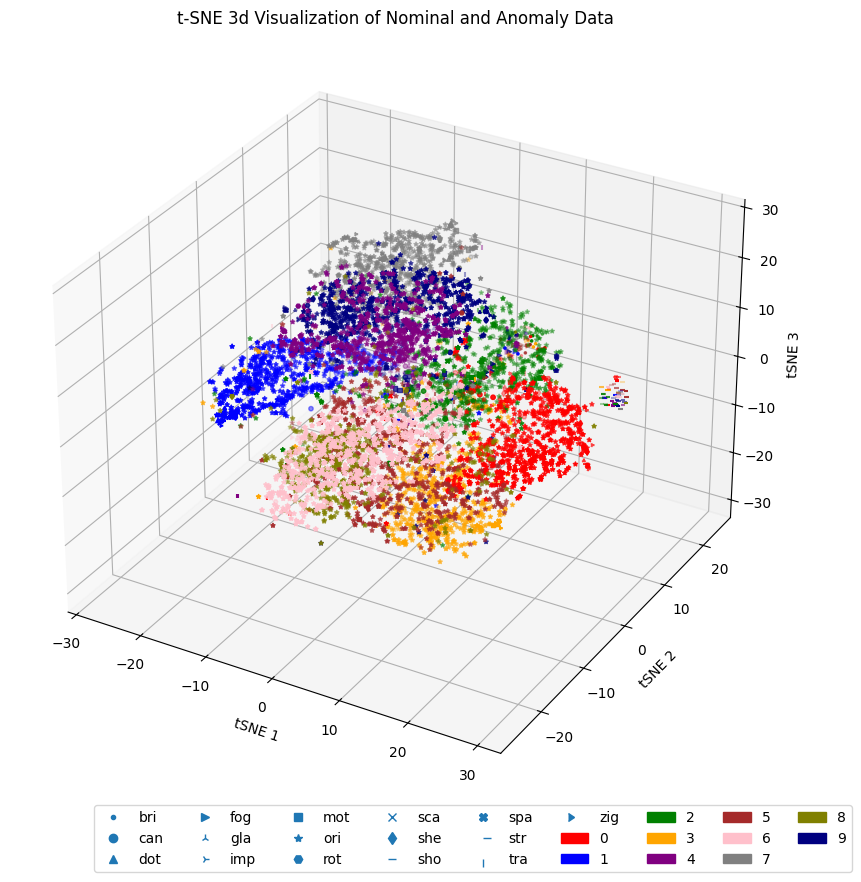

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [ ]:
%matplotlib inline
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for ix, y_label in enumerate(y_p[0]):
    ax.scatter(X_tsne_3d[y == y_label, 0], X_tsne_3d[y == y_label, 1], X_tsne_3d[y == y_label, 2], s=10, marker=list(markers.keys())[2*list(np.unique(y_p[1])).index(y_p[1][ix])], color=color_list[list(np.unique(y_p[0])).index(y_p[0][ix])%len(color_list)])
ax.set_xlabel('tSNE 1')
ax.set_ylabel('tSNE 2')
ax.set_zlabel('tSNE 3')
bottom_right_x = np.max(X_tsne[:, 0])
bottom_right_y = np.min(X_tsne[:, 1])
#bottom_right_z = np.min(X_tsne[:, 2])

manual_legend_markers = [mlines.Line2D([bottom_right_y], [bottom_right_x], linestyle='', marker=list(markers.keys())[2*list(np.unique(y_p[1])).index(np.unique(y_p[1])[i])], label=np.unique(y_p[1])[i]) for i in range(len(list(np.unique(y_p[1]))))]
manual_legend_colors = [mpatches.Patch(color=color_list[i%len(color_list)], label=y_p[2][i]) for i in range(len(np.unique(y_p[2])))]
#legend needs to be adjusted to be in the lower left corner and horizontal
ax.legend(handles=manual_legend_markers + manual_legend_colors, loc='lower left',  bbox_to_anchor=(0.1, -0.1), ncol=9)

plt.title('t-SNE 3d Visualization of Nominal and Anomaly Data')
plt.savefig(os.path.normpath(report_images + '/tsne_3d.png'))
plt.show()
def animate(frame):
  if frame <= 30:
     ax.view_init(elev=30, azim=0, roll=0)

  if frame > 30 and frame <= 390:
    ax.view_init(elev=30, azim=(frame-30)/4, roll=0)

  if frame > 390 and frame <= 750:
    ax.view_init(elev=30+(frame-390)/4, azim=90, roll=0)

  if frame > 750 and frame <= 1110:
    ax.view_init(elev=60, azim=90, roll=(frame-750)/4)

  if frame > 1110 and frame <= 1470:
    ax.view_init(elev=60 + (frame-1110)/4, azim=90-(frame-1110)/4, roll=90+ (frame-1110)/4)
  
  plt.pause(.0005)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=1250, interval=50)
HTML(anim.to_html5_video())
anim.save(os.path.normpath(report_images + '/tsne_3d_animation.mp4'))

In [63]:

class active_model_learning():
    """
    Class for active model learning.

    Parameters:
    - model: The machine learning model to be trained.
    - accuracy_threshold: The threshold for accuracy. If the accuracy reaches or exceeds this threshold, the training stops. Default is 0.95.
    - max_iterations: The maximum number of iterations for training. Default is 1000.
    - verbose: Whether to print verbose output during training. Default is True.
    - random_state: The random state for reproducibility. Default is 42.
    - strategy_function: The strategy function for selecting the next data point to be labeled. Default is None.
    - test_split: The ratio of test data split. Default is 0.2.

    Attributes:
    - model: The machine learning model.
    - strategy_function: The strategy function for selecting the next data point to be labeled.
    - _test_split: The ratio of test data split.
    - _random_state: The random state for reproducibility.
    - confusion_matrices: List to store the confusion matrices for each iteration.
    - calculable_metrics: Dictionary to store the calculable metrics (accuracy, precision, recall, f1) for each iteration.
    - accuracy_threshold: The threshold for accuracy.
    - accuracy_threshold_reached: Whether the accuracy threshold has been reached.
    - max_iterations: The maximum number of iterations for training.
    - current_iteration: The current iteration.
    - verbose: Whether to print verbose output during training.
    - X_test: The test data.
    - y_test: The test labels.
    - _next_index: The index of the next data point to be labeled.

    Methods:
    - _select_point_from_pool: Selects a data point from the unlabeled pool and adds it to the labeled pool.
    - _train_model: Trains the model on the labeled data.
    - test_model: Tests the model on the given data and stores the confusion matrix.
    - _test_model: Tests the model on the test data.
    - evaluate_model: Evaluates the model on the given data and calculates the accuracy, precision, recall, and f1 score.
    - _evaluate_model: Evaluates the model on the test data.
    - utility_function: Calculates the utility function for the given data.
    - utility_function_index: Calculates the index of the data point with the highest uncertainty.
    - _utility_function_index: Calculates the index of the next data point to be labeled.
    - _run_next: Checks if the training should continue to the next iteration.
    - report: Prints the final accuracy, confusion matrix, iteration, and whether the accuracy threshold has been reached.
    - generate_graphs: Generates and displays graphs of the confusion matrices and accuracy over iterations.
    """
    def __init__(self, model, accuracy_threshold=0.95, max_iterations=1000, verbose=True, random_state=42, strategy_function=None,  test_split=0.2, save_path=None, classes_to_discover=None, data_name=None):
        self.model = model
        self.strategy_function = strategy_function
        
        self._test_split = test_split
        self._random_state = random_state                  
        
        self.Dl_X = None
        self.Dl_y = None
        self.Du_X = None
        self.Du_y = None
        self.Du = None
        self.Dl = None
        self.Il = None
        self.Iu = None
        self.Io = None
        
        self.confusion_matrices = []
        self.calculable_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": [], "pr_auc": []}
        self.accuracy_threshold = accuracy_threshold
        self.accuracy_threshold_reached = False
        self.max_iterations = max_iterations
        self.current_iteration = 0
        self.verbose = verbose
        self.X_test = None
        self.y_test = None
        self._next_index=0
        self.save_path = save_path
        self._classes_discovered = [0]
        self._classes_to_discover = classes_to_discover
        self.discovery_threshold_reached = False
        self.data_name = data_name
        
    def _select_point_from_pool(self):
        """
        Selects a data point from the unlabeled pool and adds it to the labeled pool.
        """
        if self.Dl_X.shape[0] == 0:
            self.Dl_X = self.Du_X[self._next_index].reshape(1, -1)
            self.Dl_y = np.array([self.Du_y[self._next_index]])
            self.Il = np.array(self.Iu[self._next_index])
        else:        
            self.Dl_X = np.append(self.Dl_X,self.Du_X[self._next_index].reshape(1, -1), axis=0)
            self.Dl_y = np.append(self.Dl_y, [self.Du_y[self._next_index]], axis=0)
            self.Il = np.append(self.Il,self.Iu[self._next_index])
        
        #remove X[index] and y[index] from Du_X and Du_y
        self.Du_X = np.delete(self.Du_X, self._next_index, axis=0)
        self.Du_y = np.delete(self.Du_y, self._next_index, axis=0)
        self.Iu = np.delete(self.Iu, self._next_index, axis=0)
    
    def _train_model(self):
        """
        Trains the model on the labeled data.
        """
        if self.verbose:
            print(f"Training model on {len(self.Dl_X)} points. Iteration {self.current_iteration} at {datetime.now()}")
            start_time = datetime.now()
            
        try:
            self.model.fit(self.Dl_X, self.Dl_y)
        except ValueError as e:
            print(f"Error: {e}")
            print(f"Model: {self.model}")
            print(f"X: {self.Dl_X}")
            print(f"y: {self.Dl_y}")
            #add data point to the model and continue
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            self._select_point_from_pool()
        
        if self.verbose:
            print(f"Training time: {datetime.now() - start_time}")
        
    def test_model(self, X, y):
        """
        Tests the model on the given data and stores the confusion matrix.

        Parameters:
        - X: The input data.
        - y: The true labels.
        """
        try:
            y_pred = self.model.predict(X)
        except ValueError as e:
            print(f"Error: {e} Model: {self.model} X: {X} y: {y}")                    
            return
        
        self.confusion_matrices.append(confusion_matrix(y, y_pred))        
        
            
    def _test_model(self):            
        """
        Tests the model on the test data.
        """
        self.test_model(self.X_test, self.y_test)        
        
    def evaluate_model(self, X, y):
        """
        Evaluates the model on the given data and calculates the accuracy, precision, recall, and f1 score.

        Parameters:
        - X: The input data.
        - y: The true labels.

        Returns:
        - accuracy: The accuracy of the model.
        """
        self.test_model(X, y)
        if self._classes_to_discover is None:
            fp = (self.confusion_matrices[-1].sum(axis=0) - np.diag(self.confusion_matrices[-1]))
            fn = (self.confusion_matrices[-1].sum(axis=1) - np.diag(self.confusion_matrices[-1]))
            tp = np.diag(self.confusion_matrices[-1])
            tn = self.confusion_matrices[-1].sum() - (fn + tp + fn)
       
            accuracy = (tp + tn) / (tp + tn + fn + fp)
            #self.calculable_metrics["precision"].append(tp / (tp + fp))
            #self.calculable_metrics["recall"].append(tp / (tp + fn))
            #self.calculable_metrics["f1"].append(2 * (self.calculable_metrics["precision"][-1] * self.calculable_metrics["recall"][-1]) / (self.calculable_metrics["precision"][-1] + self.calculable_metrics["recall"][-1]))
            #self.calculable_metrics["roc_auc"].append(roc_auc_score(y, self.model.predict_proba(X)))
            #self.calculable_metrics["pr_auc"].append(auc(*precision_recall_curve(y, self.model.predict_proba(X))[:2]))    
            self.calculable_metrics["accuracy"].append(accuracy)
        else:
            if len(self._classes_discovered) == 0:
                self._classes_discovered = len(np.unique(self.Dl_y))
            else:
                self._classes_discovered.append(len(np.unique(self.Dl_y)))
            
        if self.verbose:
            if self._classes_to_discover is None:
                print(f"Accuracy for iteration {self.current_iteration}: {accuracy}")
                print(f"Confusion matrix: {self.confusion_matrices[-1]}")
            else:        
                print(f"Classes discovered: {self._classes_discovered[-1]}")
        
        if self._classes_to_discover is not None:
            if self._classes_discovered[-1] >= self._classes_to_discover:
                self.discovery_threshold_reached = True
                if self.verbose:
                    print(f"Classes to discover reached at iteration {self.current_iteration}")
            return self._classes_discovered[-1]
        else:
            if accuracy.min() >= self.accuracy_threshold:
                self.accuracy_threshold_reached = True
            if self.verbose:
                print(f"Accuracy threshold reached at iteration {self.current_iteration}")
            return accuracy

    def _evaluate_model(self):
        """
        Evaluates the model on the test data.

        Returns:
        - accuracy: The accuracy of the model.
        """
        return self.evaluate_model(self.X_test, self.y_test)
        
    def utility_function(self, X):
        """
        Calculates the utility function for the given data.

        Parameters:
        - X: The input data.

        Returns:
        - utility: The utility values for the data points.
        """
        #return the point with the highest uncertainty
        try:
        
            if self.strategy_function is None:
                #check if the model has a predict_proba method
                if not hasattr(self.model, "predict_proba"):
                    array = np.zeros(X.shape[0])
                    array[np.random.randint(0, X.shape[0])] = 1
                    return array                
                    
                return self.model.predict_proba(X)
            else:
                return self.strategy_function(self, X)
        except ValueError as e:
            print(f"Error: {e} Model: {self.model} X: {X}, using random strategy.")
            array = np.zeros(X.shape[0])
            array[np.random.randint(0, X.shape[0])] = 1
            return array
    
    def utility_function_index(self, X):
        """
        Calculates the index of the data point with the highest uncertainty.

        Parameters:
        - X: The input data.

        Returns:
        - index: The index of the data point with the highest uncertainty.
        """
        #return the point index with the highest value        
                
        return np.argmax(self.utility_function(X))
    
    def _utility_function_index(self):
        """
        Calculates the index of the next data point to be labeled.

        Returns:
        - index: The index of the next data point to be labeled.
        """
        #return the point with the highest uncertainty
        self._next_index = np.argmax(self.utility_function(self.Du_X))
        
        if self._next_index >= self.Du_X.shape[0]:
            if self.verbose:
                print(f"Index out of range: {self._next_index}")
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            
        if self.verbose:
            print(f"Selected index {self._next_index} for iteration {self.current_iteration}")
        return self._next_index
    def _run_next(self):
        """
        Checks if the training should continue to the next iteration.

        Returns:
        - continue_training: Whether the training should continue to the next iteration.
        """
        self.current_iteration += 1
        if self.accuracy_threshold_reached:
            return False
        if self.discovery_threshold_reached:
            return False
        if self.current_iteration >= self.max_iterations:
            return False
        return True
    
    def report(self):
        """
        Prints the final accuracy, confusion matrix, iteration, and whether the accuracy threshold has been reached.
        """
        if(self._classes_to_discover is not None):
            print(f"Classes to discover: {self._classes_to_discover}, Classes discovered: {self._classes_discovered}")
            
        else:
            print(f"Final accuracy: {self.evaluate_model(self.X_test, self.y_test)}")
            print(f"Final confusion matrix: {self.confusion_matrices[-1]}")
            print(f"Final iteration: {self.current_iteration}")
            print(f"Final accuracy threshold reached: {self.accuracy_threshold_reached}")
            
    
    def generate_graphs(self, save_figs=False, save_data=False, save_path=None, subtitle=None):
        """
        Generates and displays graphs of the confusion matrices and accuracy over iterations.
        """
        #add 5 confusion matrices images into the main plot as insets
        figs = []
        axes = []
        
        if(self._classes_to_discover is None):
            fig, ax = plt.subplots(1, 5, figsize=(20, 4))
            figs.append(fig)
            axes.append(ax)
            indices_to_plot = np.linspace(1, len(self.confusion_matrices), 5).astype(int)
        
                
            for i in range(5):
                ax[i].imshow(self.confusion_matrices[indices_to_plot[i]-1], cmap='binary')
                ax[i].set_title(f"Confusion matrix {indices_to_plot[i]}")
            fig.suptitle(f"Confusion matrices for {self.model.__class__.__name__} {subtitle}", fontsize=24)
            
            fig.show()      
            
            fig, ax = plt.subplots(figsize=(20, 20))
            figs.append(fig)
            axes.append(ax)
            ax.plot(self.calculable_metrics["accuracy"], label=np.unique(self.Du_y))
            ax.set_title(f"Accuracy over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__} {subtitle}", fontsize=24)
            ax.set_xlabel("Iteration", fontsize=18)
            ax.set_ylabel("Accuracy", fontsize=18)  
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.legend(prop={'size': 14})                  
            plt.show()
            
            fig, ax = plt.subplots(figsize=(20, 20))
            figs.append(fig)
            axes.append(ax)
            ax.plot(np.average(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Average accuracy")
            ax.plot(np.amin(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Minimum accuracy")
            ax.plot(np.amax(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Maximum accuracy")
            ax.set_title(f"Average accuracy over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__} {subtitle}", fontsize=24)
            ax.set_xlabel("Iteration", fontsize=18)
            ax.set_ylabel("Accuracy", fontsize=18)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_ylim([0, 1])
            ax.set_xlim([0, self.current_iteration])    
            
            
            ax.legend(prop={'size': 14})
            
            #add confusion matrix images into the main plot as insets
            #MARK: add confusion matrix images into the main plot as insets
            for i in range(5):
                #ax_inset = fig.add_axes([indices_to_plot[i]-1, indices_to_plot[i]+self.current_iteration/5, 0.4, 0.4 ])
                
                height_new_plot = 0.125
                width_new_plot = 0.125
                y_range = fig.axes[0].get_ylim()[1] - fig.axes[0].get_ylim()[0]            
                x_range = fig.axes[0].get_xlim()[1] - fig.axes[0].get_xlim()[0]
                
                y_point = np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]
                x_point = indices_to_plot[i] - 1
                                        
                left_position =  0.02+(i/6.5)
                bottom_position = 0.25#(y_relative - height_new_plot) if y_relative < 0.5 else (y_relative + height_new_plot)
                            
                ax_inset = fig.add_axes([left_position+width_new_plot, bottom_position,width_new_plot,height_new_plot ],alpha=0.5)
                
                ax_inset.imshow(self.confusion_matrices[indices_to_plot[i]-1], cmap='binary')
                ax_inset.set_xticks(np.arange(0.5, 10.5, 1))
                ax_inset.set_yticks(np.arange(0.5, 10.5, 1))
                ax_inset.set_xticklabels(np.arange(0, 10, 1))
                ax_inset.set_yticklabels(np.arange(0, 10, 1))
                ax_inset.grid(True)
                #now draw a line to the data point
                
                #ax.plot([indices_to_plot[i]-1, indices_to_plot[i]-1], [bottom_position, np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]], color='black', linestyle='--')
                
                ax_inset.set_title(f"Confusion matrix {indices_to_plot[i]}", fontsize=18)           
                #ax_inset.set_title(f"{left_position:0.2f}, {bottom_position:0.2f}, {width_new_plot:0.2f}, {height_new_plot:0.2f}")
            plt.show()
        
        
        
            if(save_figs == True) and ((self.save_path != None) or (save_path != None)):
                if save_path == None:
                    save_path = self.save_path
                
                figs[0].suptitle(f"Confusion matrices for {self.model.__class__.__name__}\n{'default strategy' if self.strategy_function==None else self.strategy_function.__name__} strategy {subtitle}")
                figs[0].savefig(os.path.normpath(save_path +f"/confusion_matrices_{self.model.__class__.__name__}_{'default strategy' if self.strategy_function==None else self.strategy_function.__name__}_{subtitle}.png"))
                axes[1].set_title(f"Accuracy over iterations\nactive learning with {self.model.__class__.__name__} and {'default strategy' if self.strategy_function==None else self.strategy_function.__name__} strategy {subtitle}")
                figs[1].savefig(os.path.normpath(save_path +f"/active_learning_{self.model.__class__.__name__}_{'default strategy' if self.strategy_function==None else self.strategy_function.__name__}_{subtitle}.png"))
                figs[2].savefig(os.path.normpath(save_path +f"/active_learning_{self.model.__class__.__name__}_{'default strategy' if self.strategy_function==None else self.strategy_function.__name__}_average_{subtitle}.png"))
            if(save_figs == True) and ((self.save_path != None) or (save_path != None)):
                if save_path == None:
                    save_path = self.save_path 
            
                np.savez(f"active_learning_{self.model.__class__.__name__}_{'default strategy' if self.strategy_function==None else self.strategy_function.__name__}_{subtitle}.npz", confusion_matrices=self.confusion_matrices, calculable_metrics=self.calculable_metrics, allow_pickle=True)
        
        else:
            fig, ax = plt.subplots(figsize=(10, 10))
            figs.append(fig)
            axes.append(ax)

            ax.scatter( np.arange(0, len(self._classes_discovered)), self._classes_discovered)
            ax.set_title(f"Classes discovered over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__} {subtitle}", fontsize=24)
            ax.set_xlabel("Iteration", fontsize=18)
            ax.set_ylabel("Classes discovered", fontsize=18)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.legend(prop={'size': 14})
            
            #add 5 data labels, at 1/5, 2/5, 3/5, 4/5, 5/5 as text

            for i in range(5):
                ax.text( (1+i)*(len(self._classes_discovered)/5), self._classes_discovered[(1+i)*(len(self._classes_discovered)//5)-1]-3, f"{self._classes_discovered[(1+i)*(len(self._classes_discovered)//5)-1]}", fontsize=14)                

            #add grid
            ax.grid(True)

            if(save_figs == True) and ((self.save_path != None) or (save_path != None)):
                if save_path == None:
                    save_path = self.save_path
                
                #fig.suptitle(f"Classes discovered for {self.model.__class__.__name__}\n{'default strategy' if self.strategy_function==None else self.strategy_function.__name__} strategy {subtitle}")
                fig.savefig(os.path.normpath(save_path +f"/classes_discovered_{self.model.__class__.__name__}_{'default strategy' if self.strategy_function==None else self.strategy_function.__name__}_{subtitle}.png"))
                np.savez(f"classes_discovered_{self.model.__class__.__name__}_{'default strategy' if self.strategy_function==None else self.strategy_function.__name__}_{subtitle}.npz", classes_discovered=self._classes_discovered, allow_pickle=True)

            plt.show()

            
            #this is a discovery problem, the graphs are different

        return figs, axes
    
    
    def fit(self, X, y):
        
        if self._classes_to_discover is None:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self._test_split, random_state=self._random_state)           
        else: # discovery is a different problem than accuracy
            self.X_train, self.X_test, self.y_train, self.y_test = X, X, y, y
                        
        self.Du_X = np.array(self.X_train); self.Du_y = np.array(self.y_train); self.Iu = np.arange(0,len(self.Du_X)); self.Du = (self.Du_X, self.Du_y)
        #match the shape of the data, except for the index column which will be 1
        #shape = list(X.shape); shape[0] = 1; shape = tuple(shape)
        self.Dl_X = np.array([]); self.Dl_y = np.array([]); self.Dl = (self.Dl_X, self.Dl_y) 
        
        #select a point from the pool at random
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()                     
               
        
        #verify the second selected point does not match the class of the first
        while self.Du_y[self._next_index] == self.Dl_y[0]:
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()
        self._train_model()               
        
        while self._run_next():   
            self._utility_function_index()
            self._select_point_from_pool()
            self._train_model()
            self._evaluate_model()
                        
        if self.verbose:
            print(f"Model training complete at iteration {self.current_iteration}")
            
        if self._classes_to_discover is not None:
            print(f"Classes discovered: {len(self._classes_discovered)}")
            return self.discovery_threshold_reached
        
        return self.accuracy_threshold_reached


def default_strategy(obj, X):
    return obj.model.predict_proba(X)

def min_neighborhood_strategy(obj, X):
    #for each point calculate the distance to their nearest neighbor
    distances = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        distances[i] = np.min(np.linalg.norm(X - X[i]))
        
    return distances


def random_strategy(obj, X):
    array = np.zeros(X.shape[0])
    array[np.random.randint(0, X.shape[0])] = 1
    return array    

def uncertainty_strategy(obj, X):
    return 1-obj.model.predict_proba(X).max(axis=1)

def entropy_strategy(obj, X):
    #return -np.sum(obj.model.predict_proba(X) * np.log(obj.model.predict_proba(X)), axis=1) 
    return -obj.model.predict_proba(X) * np.log(obj.model.predict_proba(X))

def lowest_vote_strategy(obj, X):
    #get the predictions from the model
    predictions = obj.model.predict(X)
    #get the unique predictions
    unique_predictions = np.unique(predictions)
    #get the number of unique predictions
    number_of_unique_predictions = unique_predictions.shape[0]
    #create an array to store the votes
    votes = np.zeros((X.shape[0], number_of_unique_predictions))
    #for each unique prediction
    for i, unique_prediction in enumerate(unique_predictions):
        #get the votes for the unique prediction
        votes[:, i] = predictions == unique_prediction
    #return the votes in least order to add least voted for points    
    return -votes

def knn_density_k10_strategy(obj, X):
    #get the k nearest neighbors
    k = 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #return the sum of the distances
    return np.sum(distances, axis=1)

def knn_density_k3_strategy(obj, X):
    #get the k nearest neighbors
    k = 3
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #return the sum of the distances
    return np.sum(distances, axis=1)

def knn_density_k3_oscillate_strategy(obj, X):
    #get the k nearest neighbors
    k = 3
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #if the last iteration did not find a new class, then set oscillate to oscillate *= -1
    if len(obj._classes_discovered) < k:
        return obj.model.predict_proba(X).max(axis=1)

    if obj._classes_discovered[-1] == obj._classes_discovered[-2]:
        oscillate = 1
    else:
        oscillate = -1
    #return the sum of the distances    
    return oscillate * np.sum(distances, axis=1)

def knn_density_sigma_strategy(obj, X):
    #get the k nearest neighbors
    k = 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #return the sum of the distances
    return np.std(distances, axis=1) # searching for the derivative of the density, low sigma means low change in density over k point distances

def knn_density_range_strategy(obj, X):
    #get the k nearest neighbors
    k = 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #return the sum of the distances
    return np.max(distances, axis=1) - np.min(distances, axis=1) # searching for the derivative of the density, low range means low change in density over k point distances

def knn_density_minavg_strategy(obj, X):
    #get the k nearest neighbors
    k = 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #return the sum of the distances
    return np.sum(distances, axis=1) / max(0.001,np.min(distances, axis=1)) # if there are mutiple points far away and one nearby this value will be large. if this point is all alone, this value will be close to the real average. This might orphan single points.

def knn_k10_mahalanobis_uncertainty_strategy(obj, X):
    #get the k nearest neighbors
    k = 10
    knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'V': np.cov(obj.Du_X)})
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    #return the sum of the distances
    return 1-np.sum(distances, axis=1)

def knn_point_subtraction_strategy(obj, X):
    k=10
    threshold=0.5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(obj.Du_X, obj.Du_y)
    distances, indices = knn.kneighbors(X)
    original_sum = np.sum(distances, axis=1)
    sorted_distances = np.sort(distances, axis=1)
    working_sum = original_sum - np.sum(sorted_distances[:, 0:4], axis=1) #remove first 4 distances to save time
    items_removed = np.zeros(X.shape[0])
    #remove a distance from each point until the sum is threshold*original_sum. keep track of the number of items removed and use that in the return
    for i in range(X.shape[0]):
        for j in range(4, k):
            if working_sum[i] <= threshold * original_sum[i]:
                break
            working_sum[i] -= sorted_distances[i, j]
            items_removed[i] += 1
        items_removed[i] *= sorted_distances[i, -1] #multiply the number of items removed by the largest distance
             
    return items_removed
    
__STATIC__k=0 #static-like variable
__STATIC__t=0
__STATIC__k_reset = 0
__STATIC__t_reset = 0
def knn_point_subtraction_label_check_strategy(obj, X):    
    global __STATIC__k
    global __STATIC__t
    global __STATIC__k_reset
    global __STATIC__t_reset
    ##hyper parameters
    
    increase_threshold_after_N_unsuccessful_iterations = 3   
    max_k = 50      
    k_reset = 2
    max_t = 0.95
    t_reset = 0.2
    t_factor = 1.5
    k_factor = 1
    reset_buffer = 2
   
        
    if len(obj._classes_discovered) <= increase_threshold_after_N_unsuccessful_iterations:        
        __STATIC__t = t_reset
        __STATIC__k = k_reset
        
    #if the last N iterations did not find a new class, increase the t value         until it resets then increase the k value
    if len(obj._classes_discovered) > increase_threshold_after_N_unsuccessful_iterations:
        if  __STATIC__t_reset == 0 and obj._classes_discovered[-increase_threshold_after_N_unsuccessful_iterations:].count(obj._classes_discovered[-1]) >= increase_threshold_after_N_unsuccessful_iterations:
            if __STATIC__t == max_t: #max threshold value
                __STATIC__t = t_reset #reset threshold value
                if __STATIC__k == max_k: #max k value
                    __STATIC__k = k_reset #reset k value
                __STATIC__k = min(__STATIC__k+k_factor, max_k)               
                if obj.verbose :
                    print(f'increasing k to {__STATIC__k}')
            
            __STATIC__t = min(__STATIC__t*t_factor, max_t)
            __STATIC__t_reset = increase_threshold_after_N_unsuccessful_iterations + reset_buffer
            if obj.verbose:
                print(f'increasing threshold to {__STATIC__t}')
                
        __STATIC__t_reset = max(0, __STATIC__t_reset-1)
    
    index_range_max = max(int((__STATIC__k*__STATIC__t)-1),1)
    index_range = slice(0,index_range_max)
    knn = KNeighborsClassifier(n_neighbors=__STATIC__k)
    knn.fit(obj.X_test, obj.y_test)
    distances, indices = knn.kneighbors(obj.Du_X)
    original_sum = np.sum(distances, axis=1)
    sorted_distances = np.sort(distances, axis=1)
    working_sum = original_sum - np.sum(sorted_distances[:,index_range], axis=1) #remove first 4 distances to save time
    items_removed = np.zeros(X.shape[0])
    #remove a distance from each point until the sum is threshold*original_sum. keep track of the number of items removed and use that in the return
    for i in range(indices.shape[0]):
        if np.max(np.in1d(obj.Iu[indices[i,index_range]], obj.Il)) : #if nearby points are already labeled, skip this point
            items_removed[i] = 0
            continue
        for j in range(index_range_max,__STATIC__k):
            if working_sum[i] <= __STATIC__t * original_sum[i]:
                break
            working_sum[i] -= sorted_distances[i, j]
            items_removed[i] += 1
        #items_removed[i] = items_removed[i] ** 2
        items_removed[i] *= sorted_distances[i, -1] #multiply the number of items removed by the largest distance
             
    return items_removed
    

In [68]:
accuracy_threshold = 1
max_iterations = 2000
verbose = True
#strategies = [knn_density_minavg_strategy, knn_density_k3_oscillate_strategy, knn_density_k3_strategy, knn_density_k10_strategy, uncertainty_strategy, knn_density_sigma_strategy, knn_density_range_strategy, random_strategy]#, min_neighborhood_strategy]
#strategies = [lowest_vote_strategy]
#models = [SVC(probability=True, random_state=42),KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=10), RandomForestClassifier(n_estimators=100, random_state=42)]
#models = [ SVC(probability=True, random_state=42)]
#prepared_data = [(PCA(n_components=2).fit_transform(X), y), (TSNE(n_components=2, random_state=42).fit_transform(X), y) is preparing the data for active learning by transforming it using dimensionality reduction techniques like Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) to visualize the data in lower dimensions before feeding it to the active learning model.
#                (PCA(n_components=2).fit_transform(X), y), (TSNE(n_components=2, random_state=42).fit_transform(X), y),
#                 (PCA(n_components=3).fit_transform(X), y), (TSNE(n_components=3, random_state=42).fit_transform(X), y),
#                 (PCA(n_components=4).fit_transform(X), y), (PCA(n_components=5).fit_transform(X), y),
#                 (X,y)]

#data_titles = ['PCA 2D', 't-SNE 2D', 'PCA 3D', 't-SNE 3D', 'PCA 4D', 'PCA 5D', 'Raw Data']

strategies = [knn_point_subtraction_label_check_strategy, knn_point_subtraction_strategy]
models = [SVC(probability=True, random_state=42),  RandomForestClassifier(n_estimators=100, random_state=42),KNeighborsClassifier(n_neighbors=10)]
data_titles = [ 'Raw Data', 'PCA 10D', 'TSNE 2D', 'TSNE 3D']
if prepared_data == None:
    prepared_data = [(X,y),
                 (PCA(n_components=10).fit_transform(X), y),
                 (TSNE(n_components=2, random_state=42).fit_transform(X), y), 
                 (TSNE(n_components=3, random_state=42).fit_transform(X), y)]

active_learner = []

for ix, fit_data in enumerate(prepared_data):
    for strategy in strategies:
        for model in models:
            print(f'beginning active learning for {model.__class__.__name__} with {strategy.__name__} strategy on {data_titles[ix]} data.')
            active_learner.append(active_model_learning(model, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose, strategy_function=strategy, test_split=0.2, random_state=42, save_path=report_images, classes_to_discover=np.unique(y).shape[0], data_name=data_titles[ix]))
            active_learner[-1].fit(fit_data[0], fit_data[1])
            active_learner[-1].report()
            active_learner[-1].generate_graphs(save_figs=False, save_data=False, subtitle = data_titles[ix])
            plt.show()

beginning active learning for SVC with knn_point_subtraction_label_check_strategy strategy on Raw Data data.
Training model on 2 points. Iteration 0 at 2024-04-23 18:45:03.518678
Training time: 0:00:00


IndexError: index 6958 is out of bounds for axis 0 with size 6958

In [ ]:
a = [1,2,3,4,5,5,5]

#check if last 4 elemenets of a are equal to eachother
print(a[-4:].count(a[-1]))


3


In [ ]:
#save all the active_learner object to a file
np.savez(data_path + '/active_learner.npz', active_learner=active_learner, allow_pickle=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Classes to discover: 170, Classes discovered: [0, 2, 3, 4, 5, 6, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39

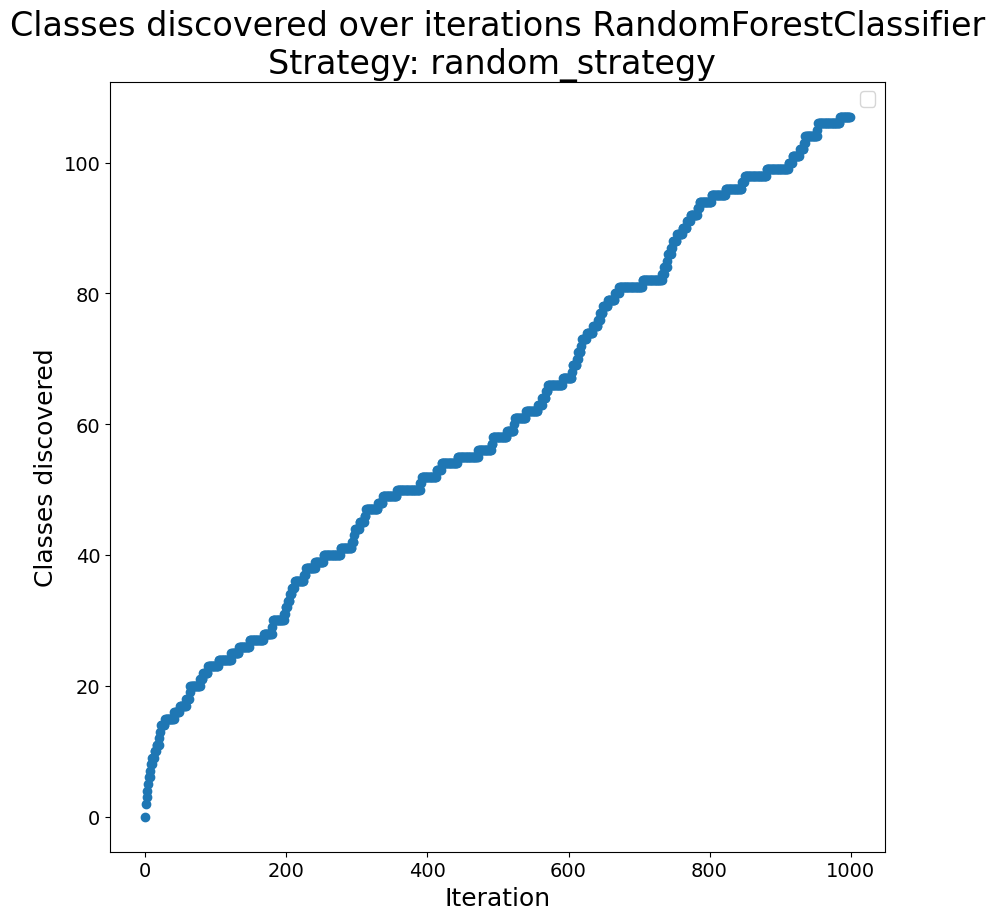

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


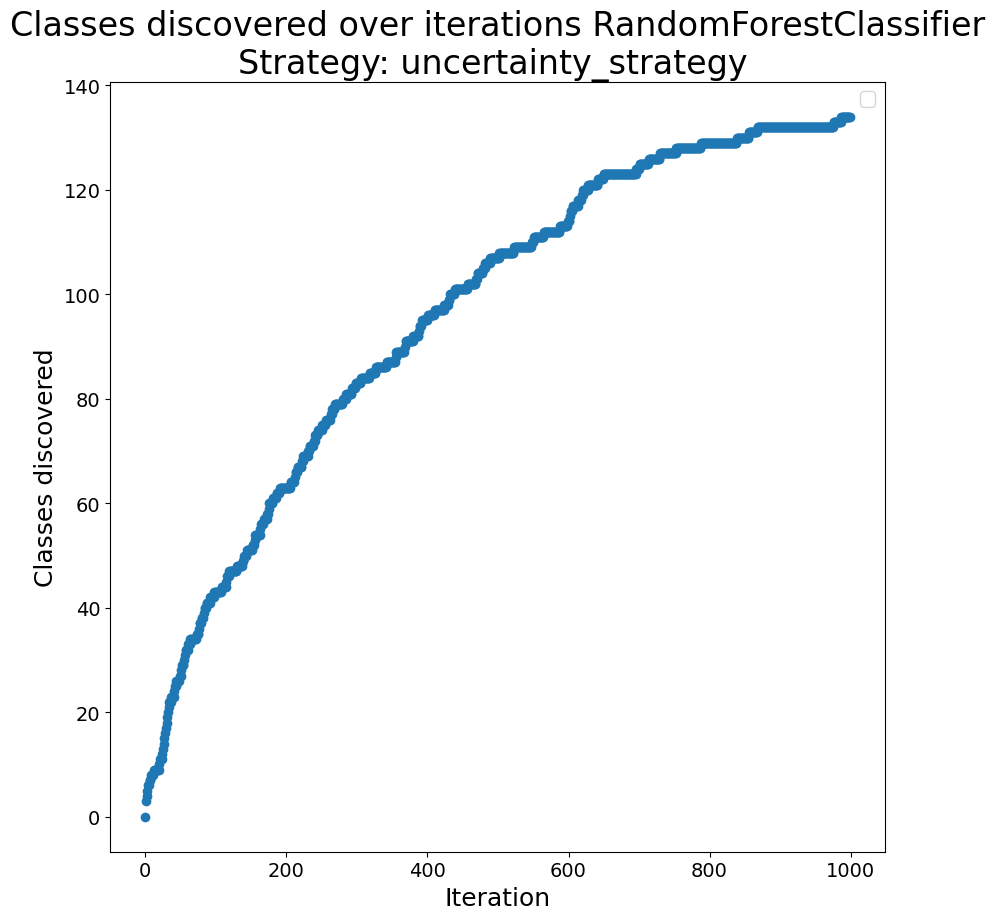

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


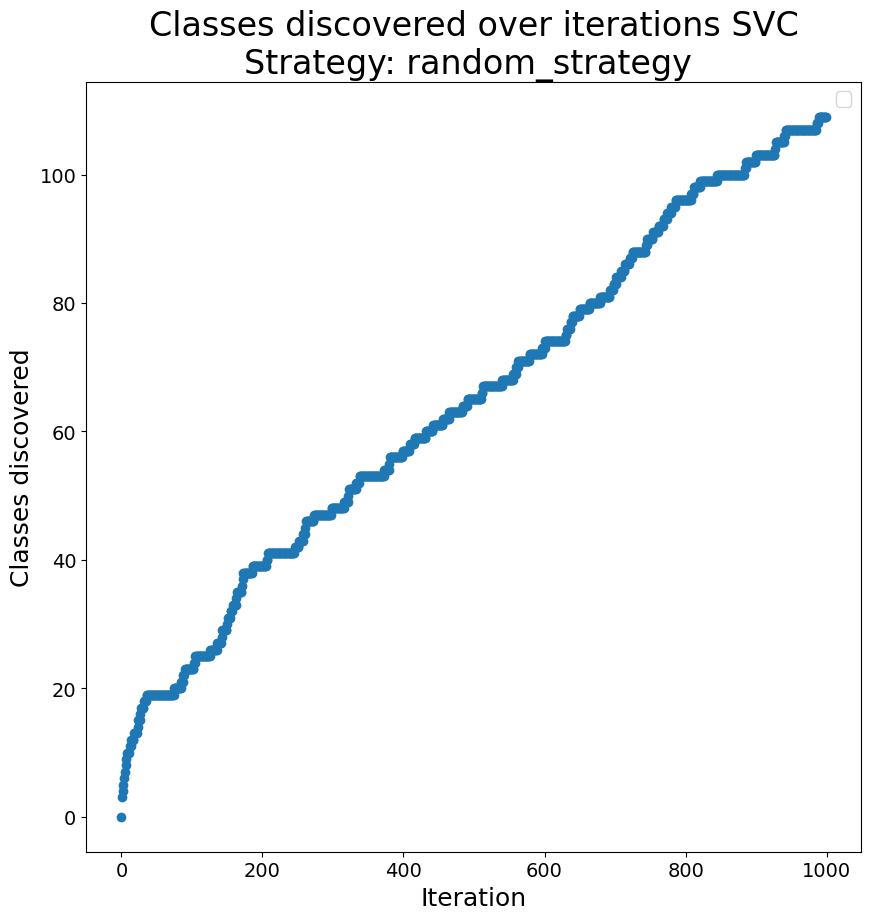

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


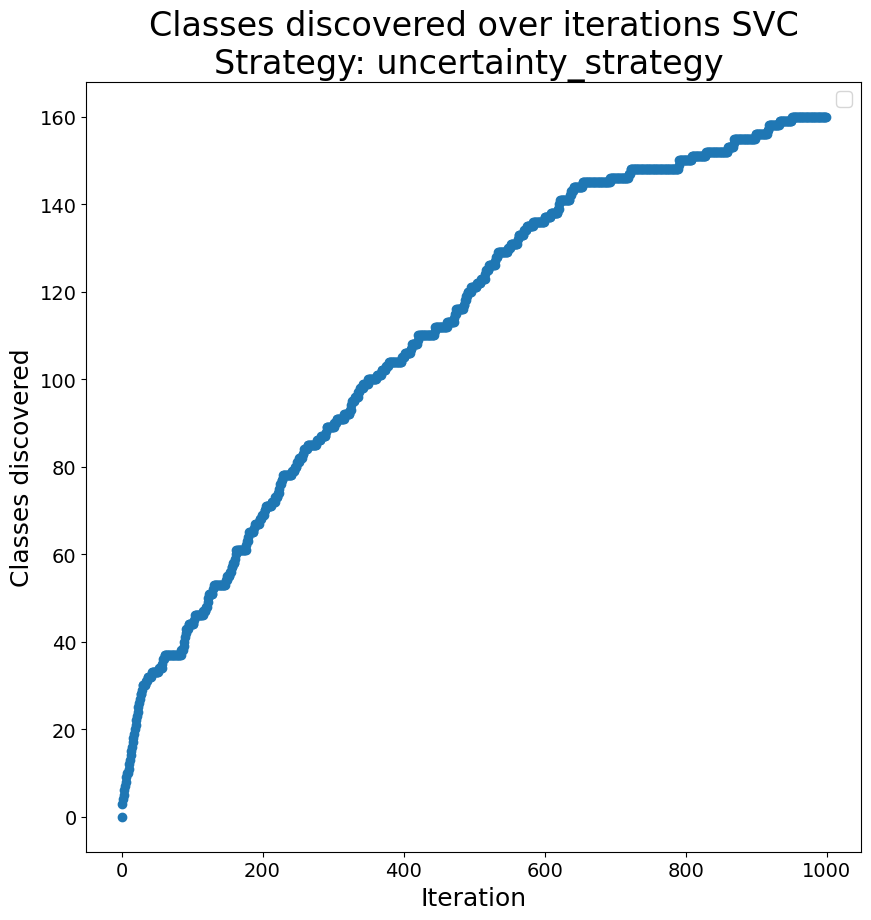

In [ ]:
test_reload = np.load(data_path + '/active_learner.npz', allow_pickle=True)
active_learner_reload = test_reload['active_learner']
active_learner_reload[0].report()
for learner in active_learner_reload:
    learner.generate_graphs(save_figs=False, save_data=False)



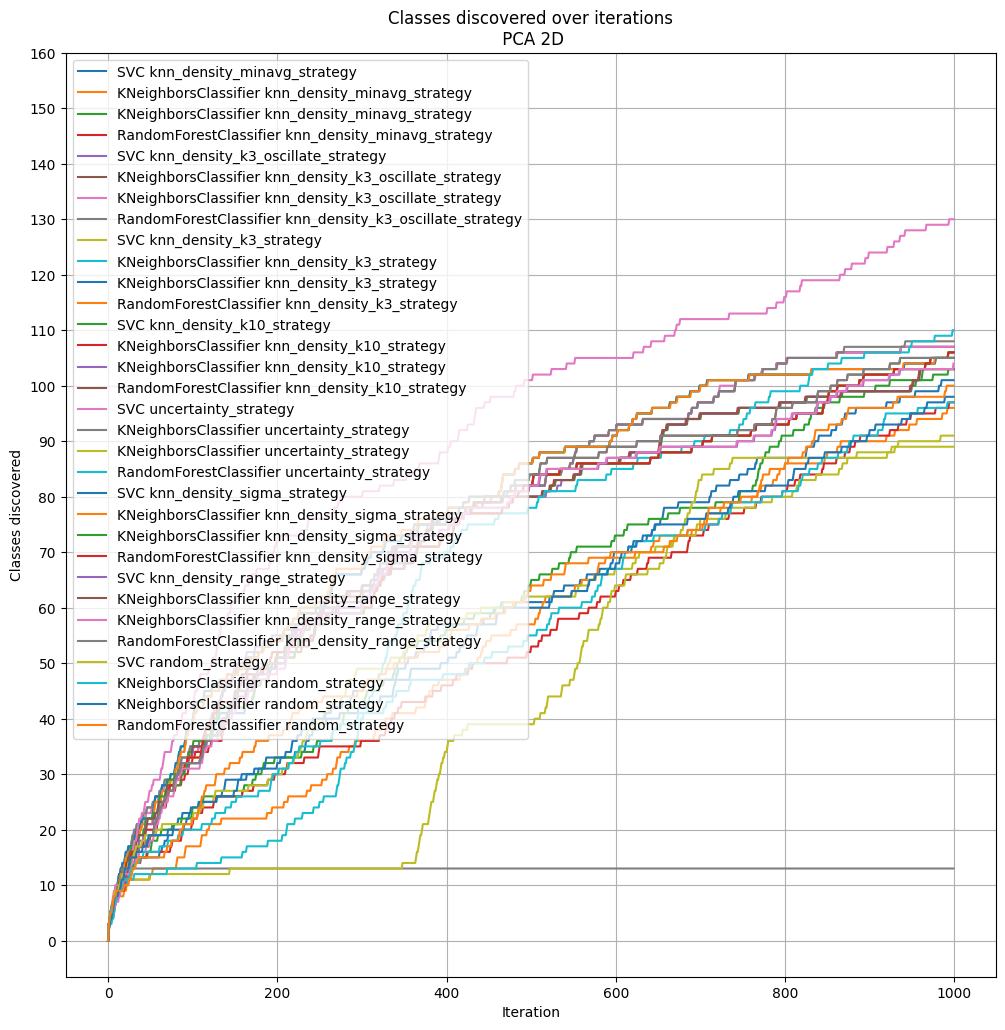

<Figure size 640x480 with 0 Axes>

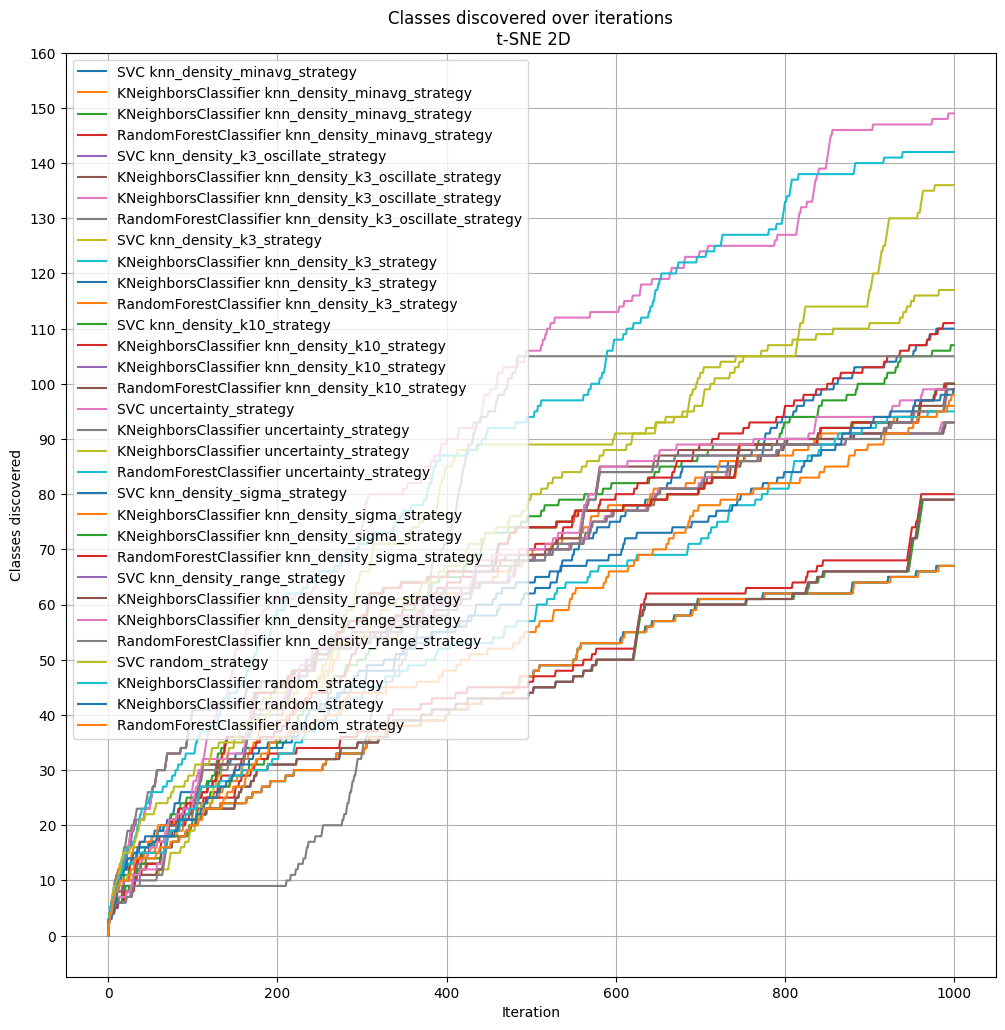

<Figure size 640x480 with 0 Axes>

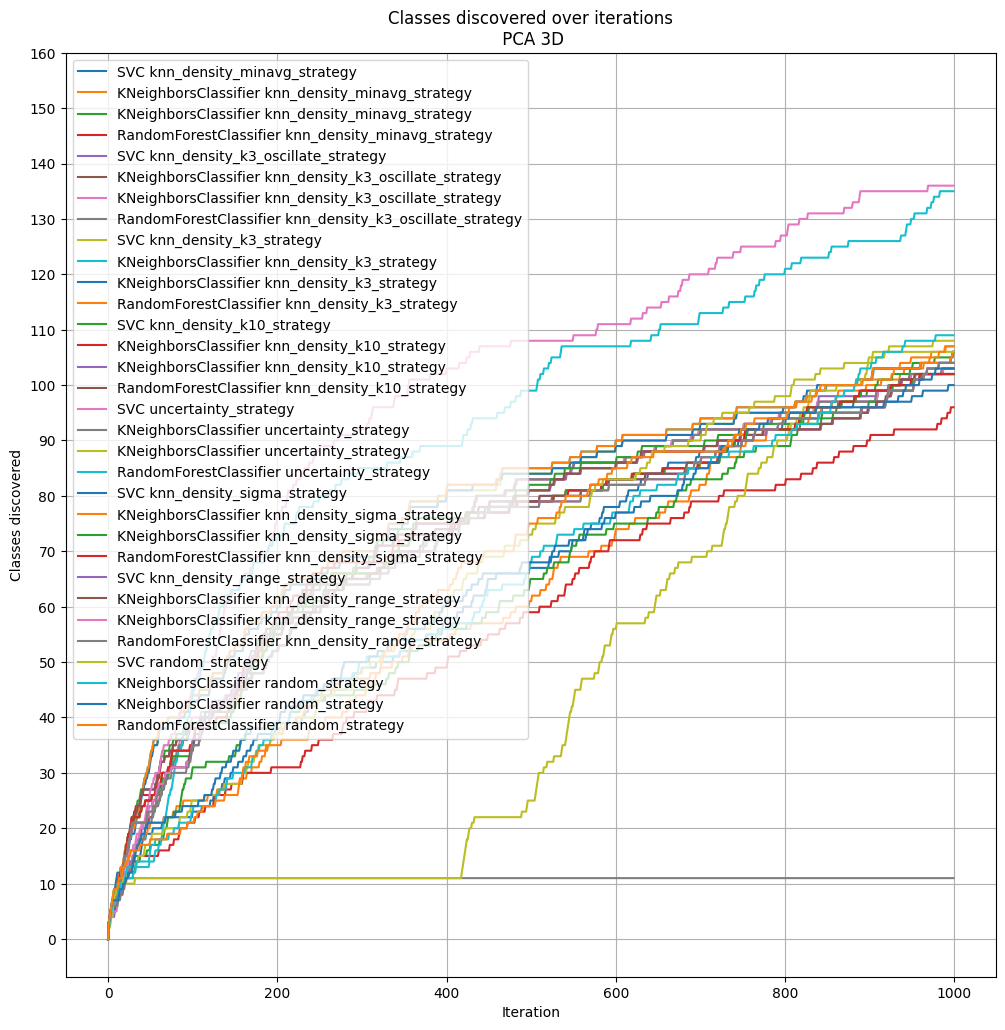

<Figure size 640x480 with 0 Axes>

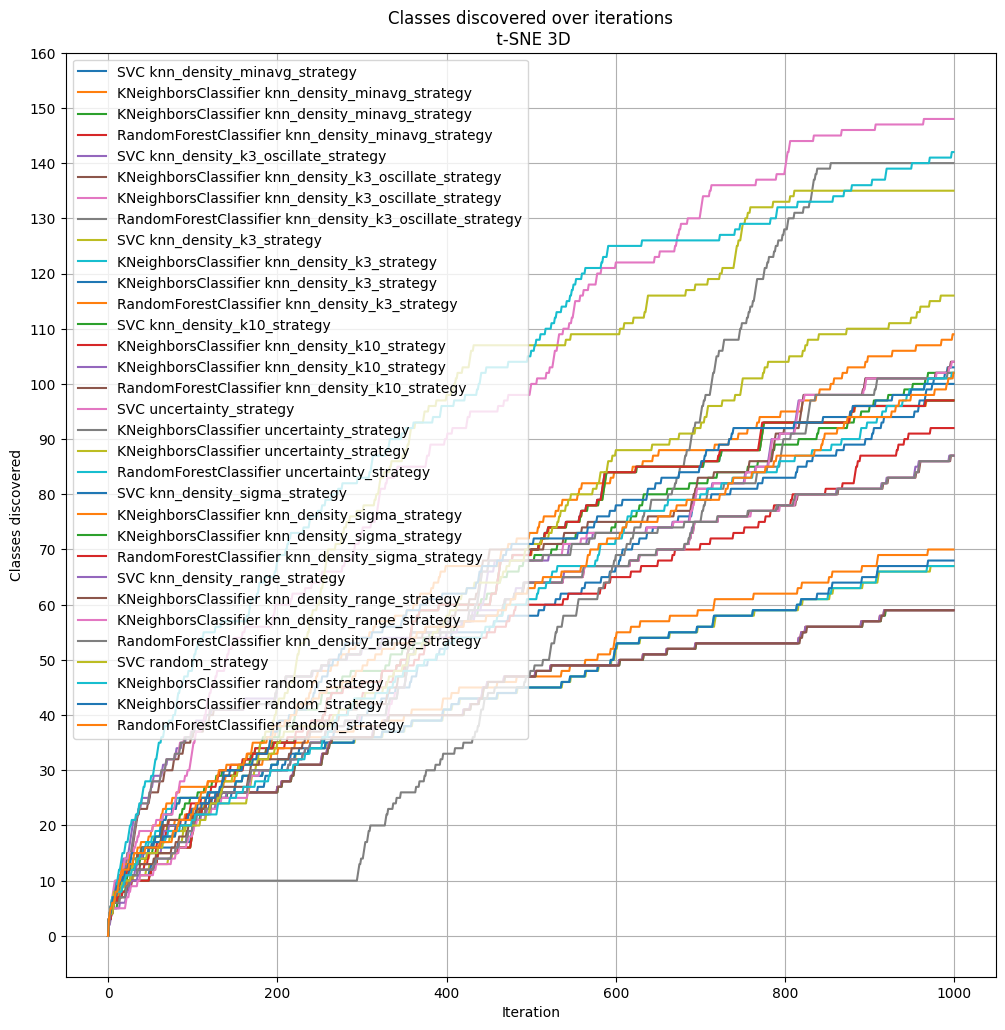

<Figure size 640x480 with 0 Axes>

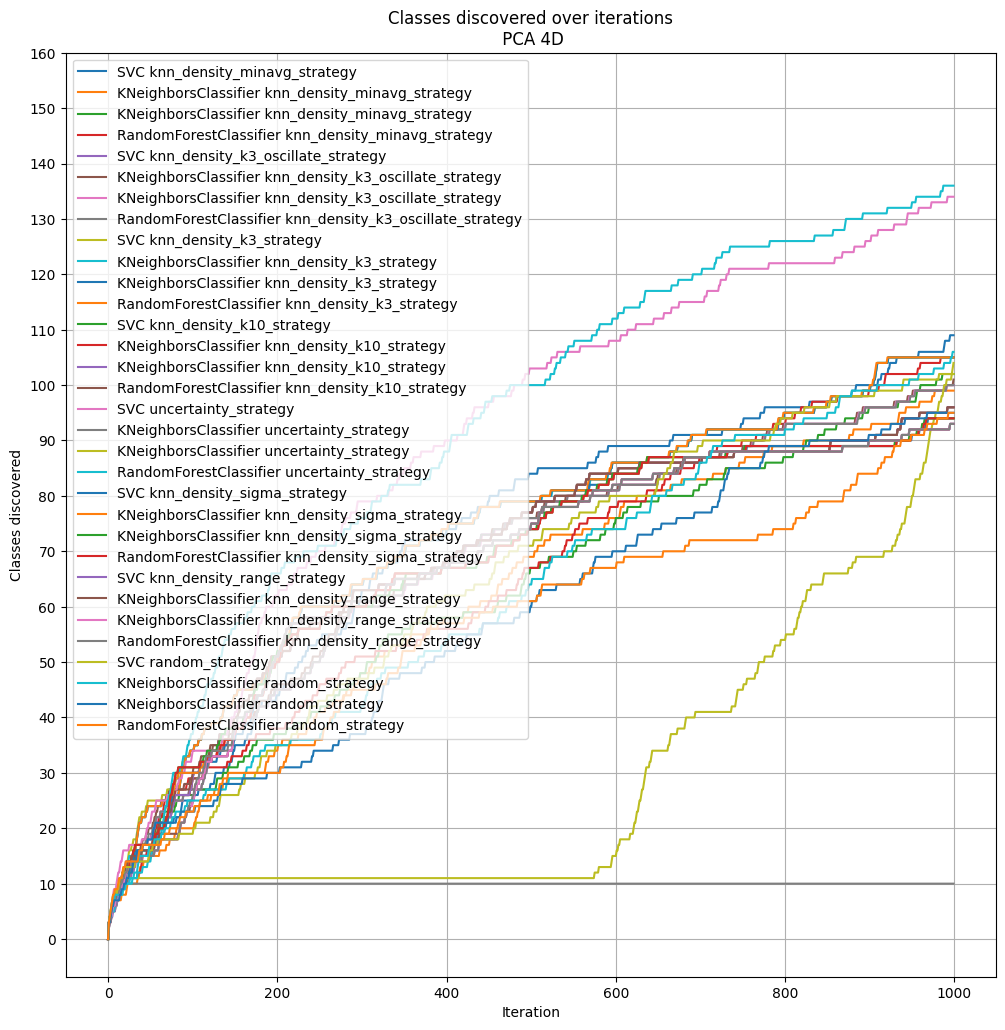

<Figure size 640x480 with 0 Axes>

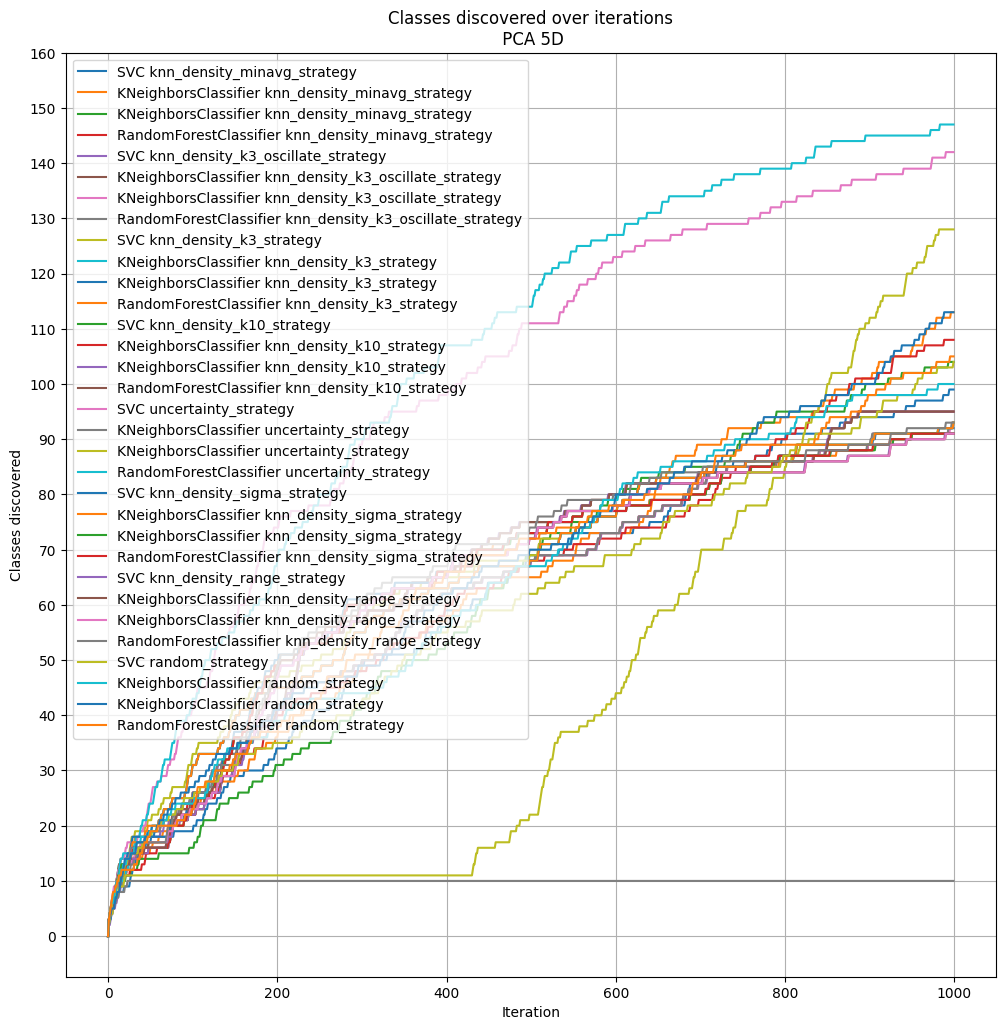

<Figure size 640x480 with 0 Axes>

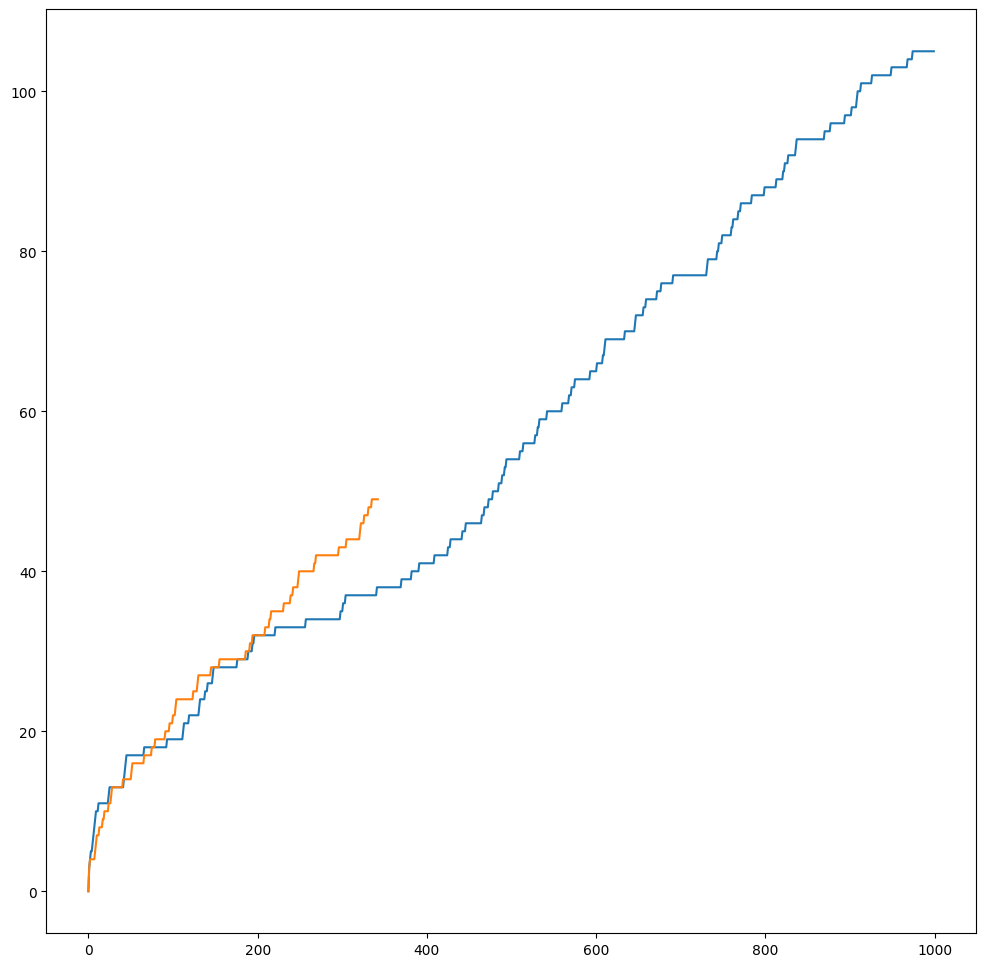

In [ ]:
#plot all active learners on a single graph
#the plot will be classes discovered vs iterations

instances_per_data_set = len(strategies) * len(models)

for index, learner in enumerate(active_learner):
    if index%instances_per_data_set==0:
        fig, ax = plt.subplots(figsize=(12, 12))       
        
    ax.plot(learner._classes_discovered, label=f"{learner.model.__class__.__name__} {learner.strategy_function.__name__}")
    
    if((index%instances_per_data_set)==(instances_per_data_set-1)):
        ax.set_title(f"Classes discovered over iterations\n {data_titles[np.floor((index-1)/instances_per_data_set).astype(int)]}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Classes discovered")
        ax.legend()
        ax.grid(True)
        ax.set_yticks(np.arange(0,170, 10))
        plt.show()
        plt.savefig(os.path.normpath(report_images + f"/classes_discovered_{data_titles[np.floor((index-1)/instances_per_data_set).astype(int)]}.png"))




    